In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm.notebook import tqdm
import pandas as pd
import pickle

from plot_3d_helpers import expanded_detector_boundary_points, detector_boundary_points
from plot_3d_helpers import fps_clustering_downsample, get_min_dists, energy_weighted_density_sampling


# Loading File

In [2]:
f = uproot.open("input_files/bdt_convert_superunified_bnb_ncpi0_full_spacepoints.root")

#events_to_load = 500
events_to_load = None

bdt_vars = [
    "nc_delta_score",
    "nc_pio_score",
    "numu_score",
    "numu_cc_flag",
    "single_photon_numu_score",
    "single_photon_other_score",
    "single_photon_ncpi0_score",
    "single_photon_nue_score",
    "shw_sp_n_20mev_showers",
    "shw_sp_n_20br1_showers",
]

kine_vars = [
    "kine_reco_Enu"
]

eval_vars = [
    "run",
    "subrun",
    "event",
    "truth_vtxX",
    "truth_vtxY",
    "truth_vtxZ",
    "match_isFC",
    "truth_isCC",
    "truth_nuPdg",
    "match_completeness_energy",
    "truth_energyInside",
]

PFeval_vars = [
    "reco_nuvtxX",
    "reco_nuvtxY",
    "reco_nuvtxZ",
    "truth_single_photon",
    "truth_muonMomentum",
]

T_BDTvars_df = f["wcpselection"]["T_BDTvars"].arrays(bdt_vars, library="pd", entry_start=0, entry_stop=events_to_load)
T_kine_df = f["wcpselection"]["T_KINEvars"].arrays(kine_vars, library="pd", entry_start=0, entry_stop=events_to_load)
T_eval_df = f["wcpselection"]["T_eval"].arrays(eval_vars, library="pd", entry_start=0, entry_stop=events_to_load)
T_PFeval_df = f["wcpselection"]["T_PFeval"].arrays(PFeval_vars, library="pd", entry_start=0, entry_stop=events_to_load)

all_df = pd.concat([T_BDTvars_df, T_kine_df, T_eval_df, T_PFeval_df], axis=1)

del f 
del T_BDTvars_df
del T_kine_df
del T_eval_df
del T_PFeval_df


# Applying WC Inclusive Single Photon Selection

In [3]:
all_df = all_df.query("kine_reco_Enu > 0")

In [4]:
"""
bool LEEana::is_singlephoton_sel(TaggerInfo& tagger_info, PFevalInfo& pfeval){
  bool flag = false;
  if (tagger_info.shw_sp_n_20mev_showers > 0 &&
    pfeval.reco_nuvtxX>5.0 && pfeval.reco_nuvtxX<250.0 &&
    tagger_info.single_photon_numu_score > 0.4 && tagger_info.single_photon_other_score > 0.2 &&
    tagger_info.single_photon_ncpi0_score > -0.05 && tagger_info.single_photon_nue_score > -1.0 &&
    tagger_info.shw_sp_n_20br1_showers==1) {flag = true;}
  return flag;
}
"""

shw_sp_n_20mev_showers_vals = all_df["shw_sp_n_20mev_showers"].to_numpy()
reco_nuvtxX_vals = all_df["reco_nuvtxX"].to_numpy()
reco_nuvtxY_vals = all_df["reco_nuvtxY"].to_numpy()
reco_nuvtxZ_vals = all_df["reco_nuvtxZ"].to_numpy()
single_photon_numu_score_vals = all_df["single_photon_numu_score"].to_numpy()
single_photon_other_score_vals = all_df["single_photon_other_score"].to_numpy()
single_photon_ncpi0_score_vals = all_df["single_photon_ncpi0_score"].to_numpy()
single_photon_nue_score_vals = all_df["single_photon_nue_score"].to_numpy()
shw_sp_n_20br1_showers_vals = all_df["shw_sp_n_20br1_showers"].to_numpy()
wc_inclusive_selected_flag = []
wc_inclusive_nc_pi0_sideband_flag = []
for i in tqdm(range(len(all_df))):
    if (shw_sp_n_20mev_showers_vals[i] > 0
         and reco_nuvtxX_vals[i] > 5.0 and reco_nuvtxX_vals[i] < 250.0
           and single_photon_numu_score_vals[i] > 0.4 and single_photon_other_score_vals[i] > 0.2
             and single_photon_ncpi0_score_vals[i] > -0.05 and single_photon_nue_score_vals[i] > -1.0
               and shw_sp_n_20br1_showers_vals[i] == 1):
        wc_inclusive_selected_flag.append(1)
    else:
        wc_inclusive_selected_flag.append(0)
    if (shw_sp_n_20mev_showers_vals[i] > 0
         and reco_nuvtxX_vals[i] > 5.0 and reco_nuvtxX_vals[i] < 250.0
           and single_photon_numu_score_vals[i] > 0.4 and single_photon_other_score_vals[i] > 0.2
             and single_photon_ncpi0_score_vals[i] < -0.05):
        wc_inclusive_nc_pi0_sideband_flag.append(1)
    else:
        wc_inclusive_nc_pi0_sideband_flag.append(0)

all_df["wc_inclusive_selected_flag"] = wc_inclusive_selected_flag
all_df["wc_inclusive_nc_pi0_sideband_flag"] = wc_inclusive_nc_pi0_sideband_flag


  0%|          | 0/8717 [00:00<?, ?it/s]

In [39]:
all_df["truth_muonMomentum_3"] = all_df["truth_muonMomentum"].to_numpy()[:, 3].astype(float)

inclusive_1g_sig_query = "(match_completeness_energy>0.1*truth_energyInside and truth_single_photon==1 and (truth_isCC==0 or (truth_isCC==1 and abs(truth_nuPdg)==14 and abs(truth_muonMomentum_3-0.105658)<0.1)))"

all_df["inclusive_1g_sig_flag"] = all_df.eval(inclusive_1g_sig_query)

print("num inclusive 1g sig:", len(all_df[all_df["inclusive_1g_sig_flag"] == 1]))
print("num inclusive 1g bkg:", len(all_df[all_df["inclusive_1g_sig_flag"] == 0]))

all_df


num inclusive 1g sig: 1298
num inclusive 1g bkg: 7419


,nc_delta_score,nc_pio_score,numu_score,numu_cc_flag,single_photon_numu_score,single_photon_other_score,single_photon_ncpi0_score,single_photon_nue_score,shw_sp_n_20mev_showers,shw_sp_n_20br1_showers,...,truth_energyInside,reco_nuvtxX,reco_nuvtxY,reco_nuvtxZ,truth_single_photon,truth_muonMomentum,wc_inclusive_selected_flag,wc_inclusive_nc_pi0_sideband_flag,truth_muonMomentum_3,inclusive_1g_sig_flag
0,-7.221196,0.733786,1.383875,1.0,-3.134760,-1.658427,-1.104319,-0.844563,0.0,0.0,...,1047.367065,222.065872,3.455418,515.080261,0,[-1.0 -1.0 -1.0 -1.0],0,0,-1.0,False
2,-7.653152,0.148902,1.234163,0.0,-1.479531,0.101909,-2.191365,-2.593808,2.0,2.0,...,585.300720,111.093262,67.926132,13.001895,0,[-1.0 -1.0 -1.0 -1.0],0,0,-1.0,False
3,-5.331586,1.689949,-0.825601,0.0,0.660477,0.590494,-1.302506,0.328553,3.0,3.0,...,228.740631,156.866974,-81.698502,912.352234,0,[-1.0 -1.0 -1.0 -1.0],0,1,-1.0,False
4,-4.057340,3.850606,-0.679879,0.0,0.462123,1.880685,-1.902228,1.174500,2.0,2.0,...,358.290466,186.317184,-49.625145,260.065735,0,[-1.0 -1.0 -1.0 -1.0],0,1,-1.0,False
5,-4.019629,-3.078938,0.581895,0.0,-1.846355,0.102059,0.733096,-1.899566,1.0,1.0,...,535.633423,32.177433,27.699005,45.055824,0,[-1.0 -1.0 -1.0 -1.0],0,0,-1.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11943,-4.076781,-1.148642,-0.008708,1.0,-0.295183,-0.320875,0.240062,-0.787019,1.0,1.0,...,238.258850,159.071274,13.450804,1022.064636,0,[-1.0 -1.0 -1.0 -1.0],0,0,-1.0,False
11944,-0.899081,2.514857,-1.214247,0.0,0.599268,-0.437205,-1.531916,-0.553344,3.0,3.0,...,573.394165,161.126526,-55.461864,281.795807,0,[-1.0 -1.0 -1.0 -1.0],0,0,-1.0,False
11946,-2.011384,0.782625,-0.588978,0.0,-1.031153,-1.214605,-0.131298,-0.765401,2.0,1.0,...,652.883362,74.898834,-86.913223,38.517525,1,[-1.0 -1.0 -1.0 -1.0],0,0,-1.0,True
11949,-6.907320,3.894584,0.233579,0.0,-0.165714,0.982578,-2.596655,-0.715463,3.0,3.0,...,936.753357,56.288555,-23.429195,337.615631,0,[-1.0 -1.0 -1.0 -1.0],0,0,-1.0,False


In [42]:
wc_inclusive_1g_sel_df = all_df.query("wc_inclusive_selected_flag == 1")

print("num inclusive 1g sig sel:", len(wc_inclusive_1g_sel_df[wc_inclusive_1g_sel_df["inclusive_1g_sig_flag"] == 1]))
print("num inclusive 1g bkg sel:", len(wc_inclusive_1g_sel_df[wc_inclusive_1g_sel_df["inclusive_1g_sig_flag"] == 0]))

wc_inclusive_1g_sel_df[["run", "subrun", "event", "wc_inclusive_selected_flag", "inclusive_1g_sig_flag"]]


num inclusive 1g sig sel: 167
num inclusive 1g bkg sel: 171


,run,subrun,event,wc_inclusive_selected_flag,inclusive_1g_sig_flag
6,20662,70,3531,1,True
61,20082,19,990,1,False
145,19842,54,2735,1,True
161,20608,62,3150,1,False
185,20608,244,12202,1,False
...,...,...,...,...,...
11825,21130,147,7365,1,True
11840,21130,229,11473,1,True
11878,21246,2,150,1,True
11911,21246,228,11428,1,False


# Processing Spacepoints

In [7]:
spacepoint_vars = [
    "Tcluster_spacepoints_x",
    "Tcluster_spacepoints_y",
    "Tcluster_spacepoints_z",
    "Trec_spacepoints_x",
    "Trec_spacepoints_y",
    "Trec_spacepoints_z",
    "TrueEDep_spacepoints_startx",
    "TrueEDep_spacepoints_starty",
    "TrueEDep_spacepoints_startz",
    "TrueEDep_spacepoints_endx",
    "TrueEDep_spacepoints_endy",
    "TrueEDep_spacepoints_endz",
    "TrueEDep_spacepoints_edep",
]

wanted_indices = wc_inclusive_1g_sel_df.index.tolist()
wanted_set = set(wanted_indices)

chunk_size = 500

spacepoints_df = pd.DataFrame()
with uproot.open("input_files/bdt_convert_superunified_bnb_ncpi0_full_spacepoints.root") as f:

    tree = f["wcpselection"]["T_spacepoints"]

    for start in tqdm(range(0, tree.num_entries, chunk_size)):  # Adjust chunk size

        stop = min(start + chunk_size, tree.num_entries)

        relevant_indices = [i for i in range(start, stop) if i in wanted_set]
        if not relevant_indices:
            continue

        curr_spacepoints_df = tree.arrays(spacepoint_vars, entry_start=start, entry_stop=stop, library="pd")

        curr_spacepoints_df.index = range(start, stop)  # Make the index reflect global entry numbers
        filtered = curr_spacepoints_df.loc[relevant_indices]

        spacepoints_df = pd.concat([spacepoints_df, filtered], ignore_index=True)
        print(f"    added {len(filtered)} events, with {len(spacepoints_df)} total in curr_spacepoints_df")     


  0%|          | 0/24 [00:00<?, ?it/s]

    added 14 events, with 14 total in curr_spacepoints_df
    added 12 events, with 26 total in curr_spacepoints_df
    added 18 events, with 44 total in curr_spacepoints_df
    added 12 events, with 56 total in curr_spacepoints_df
    added 20 events, with 76 total in curr_spacepoints_df
    added 14 events, with 90 total in curr_spacepoints_df
    added 16 events, with 106 total in curr_spacepoints_df
    added 14 events, with 120 total in curr_spacepoints_df
    added 14 events, with 134 total in curr_spacepoints_df
    added 14 events, with 148 total in curr_spacepoints_df
    added 12 events, with 160 total in curr_spacepoints_df
    added 25 events, with 185 total in curr_spacepoints_df
    added 10 events, with 195 total in curr_spacepoints_df
    added 12 events, with 207 total in curr_spacepoints_df
    added 13 events, with 220 total in curr_spacepoints_df
    added 13 events, with 233 total in curr_spacepoints_df
    added 10 events, with 243 total in curr_spacepoints_df
   

In [8]:
#wc_inclusive_1g_sel_df = pd.concat([wc_inclusive_1g_sel_df_no_sp.reset_index(drop=True), spacepoints_df.reset_index(drop=True)], axis=1)
#del wc_inclusive_1g_sel_df
#del spacepoints_df


In [9]:
rse = wc_inclusive_1g_sel_df[["run", "subrun", "event"]].to_numpy()

true_nu_vtx = wc_inclusive_1g_sel_df[["truth_vtxX", "truth_vtxY", "truth_vtxZ"]].to_numpy()
reco_nu_vtx = wc_inclusive_1g_sel_df[["reco_nuvtxX", "reco_nuvtxY", "reco_nuvtxZ"]].to_numpy()


In [10]:
spacepoints_df


,Tcluster_spacepoints_x,Tcluster_spacepoints_y,Tcluster_spacepoints_z,Trec_spacepoints_x,Trec_spacepoints_y,Trec_spacepoints_z,TrueEDep_spacepoints_startx,TrueEDep_spacepoints_starty,TrueEDep_spacepoints_startz,TrueEDep_spacepoints_endx,TrueEDep_spacepoints_endy,TrueEDep_spacepoints_endz,TrueEDep_spacepoints_edep
0,"[144.23099365234376, 144.23099365234376, 144.8...","[-62.1633056640625, -62.33651123046875, -61.90...","[523.75, 524.05, 524.5, 524.8, 525.25, 525.55,...","[148.414794921875, 148.414794921875, 148.41479...","[-59.91163330078125, -60.0848388671875, -60.08...","[527.05, 527.35, 527.35, 526.45, 527.35, 527.5...","[111.91201782226562, 111.91201782226562, 111.8...","[-91.50772857666016, -91.50772857666016, -91.5...","[484.1311950683594, 484.1311950683594, 484.121...","[111.91202545166016, 111.89177703857422, 111.8...","[-91.50772857666016, -91.50872039794922, -91.5...","[484.1311950683594, 484.121337890625, 484.1193...","[0.08172203600406647, 0.0980847179889679, 0.03..."
1,"[6.165599822998047, 6.385799789428711, 6.38579...","[47.21578369140625, 47.042578125, 47.215783691...","[951.09765625, 950.79765625, 951.09765625, 951...","[6.165599822998047, 6.385799789428711, 6.38579...","[47.21578369140625, 47.042578125, 47.215783691...","[951.09765625, 950.79765625, 951.09765625, 951...","[38.17076873779297, 38.17076873779297, 38.1707...","[117.0604248046875, 117.0604248046875, 117.060...","[833.037109375, 833.037109375, 833.037109375, ...","[38.17117691040039, 38.17002487182617, 38.1739...","[117.06035614013672, 117.0660629272461, 117.05...","[833.0369873046875, 833.04541015625, 833.05194...","[9.08780288696289, 8.435798645019531, 0.543465..."
2,"[234.51298828125, 234.51298828125, 234.5129882...","[83.58875122070313, 84.6274658203125, 84.10785...","[690.699755859375, 690.698876953125, 691.59887...","[234.51298828125, 234.51298828125, 234.5129882...","[83.58875122070313, 84.6274658203125, 84.10785...","[690.699755859375, 690.698876953125, 691.59887...","[238.04249572753906, 238.04446411132812, 238.0...","[73.8493423461914, 73.84601593017578, 73.84346...","[664.1209106445312, 664.1083984375, 664.098510...","[238.04446411132812, 238.04608154296875, 238.0...","[73.84601593017578, 73.84346008300781, 73.8356...","[664.1083984375, 664.0985107421875, 664.068542...","[0.39885273575782776, 0.2490573227405548, 0.94..."
3,"[161.18638916015624, 161.18638916015624, 161.1...","[105.84576416015625, 105.15294189453125, 106.3...","[81.25, 81.25, 82.15, 82.15, 82.75, 80.95, 81....","[162.28739013671876, 162.28739013671876, 162.2...","[107.14486083984374, 106.1056396484375, 107.40...","[84.70009155273438, 84.70008544921875, 84.85, ...","[195.17962646484375, 184.8097686767578, 183.79...","[43.65675735473633, 82.44477081298828, 109.572...","[104.70342254638672, 81.99649047851562, 68.905...","[195.17950439453125, 184.8098602294922, 183.79...","[43.656532287597656, 82.44479370117188, 109.57...","[104.7034912109375, 81.99646759033203, 68.9050...","[1.2425352334976196, 0.32691097259521484, 1.05..."
4,"[234.51298828125, 234.51298828125, 234.7331787...","[-11.933788299560547, -12.106993103027344, -11...","[730.75, 731.05, 729.85, 730.45, 730.75, 730.7...","[240.4583984375, 240.4583984375, 240.458398437...","[-8.469683837890624, -8.642888641357422, -8.29...","[719.95, 720.25, 720.25, 719.05, 719.65, 719.6...","[246.02420043945312, 189.2332000732422, 189.23...","[16.813196182250977, 17.565528869628906, 17.56...","[630.1065063476562, 636.5733032226562, 636.573...","[246.02420043945312, 189.2331085205078, 189.22...","[16.813194274902344, 17.56553077697754, 17.565...","[630.1065063476562, 636.5733032226562, 636.574...","[0.06060215085744858, 0.0001688865158939734, 0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
333,"[24.221998596191405, 24.442198181152342, 24.44...","[-74.201123046875, -74.37432861328125, -74.547...","[76.00010375976562, 76.30010375976562, 76.6001...","[28.625997924804686, 29.066400146484376, 29.06...","[-77.75180053710938, -78.6

In [11]:
spacepoints = {}
for col in spacepoints_df.columns:
    spacepoints[col] = spacepoints_df[col].to_numpy()


In [12]:
#num_events = 100
num_events = true_nu_vtx.shape[0]

Tcluster_spacepoints = []
Trec_spacepoints = []
TrueEDep_spacepoints = []
TrueEDep_spacepoints_edep = []
for event_i in tqdm(range(num_events)):
    Tcluster_spacepoints.append(np.stack([spacepoints["Tcluster_spacepoints_x"][event_i],
                                         spacepoints["Tcluster_spacepoints_y"][event_i],
                                         spacepoints["Tcluster_spacepoints_z"][event_i]], axis=-1))
    Trec_spacepoints.append(np.stack([spacepoints["Trec_spacepoints_x"][event_i],
                                      spacepoints["Trec_spacepoints_y"][event_i],
                                      spacepoints["Trec_spacepoints_z"][event_i]], axis=-1))
    starts = np.stack([spacepoints["TrueEDep_spacepoints_startx"][event_i],
                       spacepoints["TrueEDep_spacepoints_starty"][event_i],
                       spacepoints["TrueEDep_spacepoints_startz"][event_i]], axis=-1)
    midpoints = np.stack([(np.array(spacepoints["TrueEDep_spacepoints_startx"][event_i]) + np.array(spacepoints["TrueEDep_spacepoints_endx"][event_i]))/2,
                          (np.array(spacepoints["TrueEDep_spacepoints_starty"][event_i]) + np.array(spacepoints["TrueEDep_spacepoints_endy"][event_i]))/2,
                          (np.array(spacepoints["TrueEDep_spacepoints_startz"][event_i]) + np.array(spacepoints["TrueEDep_spacepoints_endz"][event_i]))/2], axis=-1)
    ends = np.stack([spacepoints["TrueEDep_spacepoints_endx"][event_i],
                     spacepoints["TrueEDep_spacepoints_endy"][event_i],
                     spacepoints["TrueEDep_spacepoints_endz"][event_i]], axis=-1)
    TrueEDep_spacepoints.append(np.concatenate([starts, midpoints, ends], axis=0))

    # assuming a third of the energy at the start, midpoint, and end
    TrueEDep_spacepoints_edep.append(np.concatenate([np.array(spacepoints["TrueEDep_spacepoints_edep"][event_i])/3,
                                                    np.array(spacepoints["TrueEDep_spacepoints_edep"][event_i])/3,
                                                    np.array(spacepoints["TrueEDep_spacepoints_edep"][event_i])/3], axis=0))


  0%|          | 0/338 [00:00<?, ?it/s]

# Downsample Spacepoints

In [13]:
close_to_reco_nu_vtx_threshold = 200
recalculate_downsampling = True
if recalculate_downsampling:
    downsampled_Tcluster_spacepoints = []
    downsampled_Trec_spacepoints = []
    downsampled_TrueEDep_spacepoints = []
    for event_i in tqdm(range(num_events)):

        nearby_reco_nu_vtx_indices = np.where(np.sqrt((Tcluster_spacepoints[event_i][:, 0] - reco_nu_vtx[event_i][0])**2
                                                    + (Tcluster_spacepoints[event_i][:, 1] - reco_nu_vtx[event_i][1])**2
                                                    + (Tcluster_spacepoints[event_i][:, 2] - reco_nu_vtx[event_i][2])**2) < close_to_reco_nu_vtx_threshold)[0]
        Tcluster_spacepoints_near_reco_nu_vtx = Tcluster_spacepoints[event_i][nearby_reco_nu_vtx_indices, :]
        downsampled_Tcluster_spacepoints.append(fps_clustering_downsample(Tcluster_spacepoints_near_reco_nu_vtx, 500))

        downsampled_Trec_spacepoints.append(fps_clustering_downsample(Trec_spacepoints[event_i], 200))

        downsampled_TrueEDep_spacepoints.append(energy_weighted_density_sampling(TrueEDep_spacepoints[event_i], TrueEDep_spacepoints_edep[event_i], 500))
        

    with open("downsampled_spacepoints.pkl", "wb") as f:
        pickle.dump((downsampled_Tcluster_spacepoints, downsampled_Trec_spacepoints, downsampled_TrueEDep_spacepoints), f)
else:
    with open("downsampled_spacepoints.pkl", "rb") as f:
        downsampled_Tcluster_spacepoints, downsampled_Trec_spacepoints, downsampled_TrueEDep_spacepoints = pickle.load(f)


  0%|          | 0/338 [00:00<?, ?it/s]

# Categorize Spacepoints

In [ ]:
real_nu_reco_nu_downsampled_spacepoints = []
real_nu_reco_cosmic_downsampled_spacepoints = []
real_cosmic_reco_nu_downsampled_spacepoints = []
real_cosmic_reco_cosmic_downsampled_spacepoints = []
far_from_vtx_downsampled_spacepoints = []

close_to_true_nu_spacepoint_threshold = 5
close_to_reco_nu_spacepoint_threshold = 5

for event_i in range(num_events):

    if len(downsampled_Tcluster_spacepoints[event_i]) == 0:
        real_nu_reco_cosmic_downsampled_spacepoints.append(np.empty((0, 3)))
        real_nu_reco_nu_downsampled_spacepoints.append(np.empty((0, 3)))
        real_cosmic_reco_nu_downsampled_spacepoints.append(np.empty((0, 3)))
        real_cosmic_reco_cosmic_downsampled_spacepoints.append(np.empty((0, 3)))
        far_from_vtx_downsampled_spacepoints.append(np.empty((0, 3)))
        continue

    # for T_cluster spacepoints, noting distances to true nu and reco nu spacepoints, and which are close to the reco nu vtx
    min_truth_dists = get_min_dists(downsampled_Tcluster_spacepoints[event_i][:, :3], downsampled_TrueEDep_spacepoints[event_i][:, :3])
    min_reco_nu_dists = get_min_dists(downsampled_Tcluster_spacepoints[event_i][:, :3], downsampled_Trec_spacepoints[event_i][:, :3])

    # assign features to spacepoints here
    close_to_truth_indices = np.where(min_truth_dists < close_to_true_nu_spacepoint_threshold)[0]
    far_from_truth_indices = np.where(min_truth_dists >= close_to_true_nu_spacepoint_threshold)[0]
    close_to_reco_nu_indices = np.where(min_reco_nu_dists < close_to_reco_nu_spacepoint_threshold)[0]
    far_from_reco_nu_indices = np.where(min_reco_nu_dists >= close_to_reco_nu_spacepoint_threshold)[0]

    # categorize spacepoints here
    real_nu_reco_nu_indices = np.intersect1d(close_to_reco_nu_indices, close_to_truth_indices)
    real_nu_reco_cosmic_indices = np.intersect1d(far_from_reco_nu_indices, close_to_truth_indices)
    real_cosmic_reco_nu_indices = np.intersect1d(close_to_reco_nu_indices, far_from_truth_indices)
    real_cosmic_reco_cosmic_indices = np.intersect1d(far_from_reco_nu_indices, far_from_truth_indices)

    real_nu_reco_cosmic_downsampled_spacepoints.append(downsampled_Tcluster_spacepoints[event_i][real_nu_reco_cosmic_indices, :])
    real_nu_reco_nu_downsampled_spacepoints.append(downsampled_Tcluster_spacepoints[event_i][real_nu_reco_nu_indices, :])
    real_cosmic_reco_nu_downsampled_spacepoints.append(downsampled_Tcluster_spacepoints[event_i][real_cosmic_reco_nu_indices, :])
    real_cosmic_reco_cosmic_downsampled_spacepoints.append(downsampled_Tcluster_spacepoints[event_i][real_cosmic_reco_cosmic_indices, :])


# Histogram

In [19]:
num_real_nu_reco_nu_spacepoints = []
num_real_nu_reco_cosmic_spacepoints = []
num_real_cosmic_reco_nu_spacepoints = []
num_real_cosmic_reco_cosmic_spacepoints = []

for event_i in range(num_events):
    num_real_nu_reco_nu_spacepoints.append(len(real_nu_reco_nu_downsampled_spacepoints[event_i]))
    num_real_nu_reco_cosmic_spacepoints.append(len(real_nu_reco_cosmic_downsampled_spacepoints[event_i]))
    num_real_cosmic_reco_nu_spacepoints.append(len(real_cosmic_reco_nu_downsampled_spacepoints[event_i]))
    num_real_cosmic_reco_cosmic_spacepoints.append(len(real_cosmic_reco_cosmic_downsampled_spacepoints[event_i]))

    if len(real_nu_reco_cosmic_downsampled_spacepoints[event_i]) > 50:
        print(event_i, len(real_nu_reco_cosmic_downsampled_spacepoints[event_i]))

wc_inclusive_1g_sel_df["num_real_nu_reco_nu_spacepoints"] = num_real_nu_reco_nu_spacepoints
wc_inclusive_1g_sel_df["num_real_nu_reco_cosmic_spacepoints"] = num_real_nu_reco_cosmic_spacepoints
wc_inclusive_1g_sel_df["num_real_cosmic_reco_nu_spacepoints"] = num_real_cosmic_reco_nu_spacepoints
wc_inclusive_1g_sel_df["num_real_cosmic_reco_cosmic_spacepoints"] = num_real_cosmic_reco_cosmic_spacepoints

wc_inclusive_1g_sel_df


30 79
137 60
280 65


/var/folders/yg/3cj9svrx2kz3bpv_6thtt7x00000gn/T/ipykernel_66878/1160659409.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/yg/3cj9svrx2kz3bpv_6thtt7x00000gn/T/ipykernel_66878/1160659409.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/yg/3cj9svrx2kz3bpv_6thtt7x00000gn/T/ipykernel_66878/1160659409.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

,nc_delta_score,nc_pio_score,numu_score,numu_cc_flag,single_photon_numu_score,single_photon_other_score,single_photon_ncpi0_score,single_photon_nue_score,shw_sp_n_20mev_showers,shw_sp_n_20br1_showers,...,truth_single_photon,truth_muonMomentum,wc_inclusive_selected_flag,wc_inclusive_nc_pi0_sideband_flag,truth_muonMomentum_3,inclusive_1g_sig_flag,num_real_nu_reco_nu_spacepoints,num_real_nu_reco_cosmic_spacepoints,num_real_cosmic_reco_nu_spacepoints,num_real_cosmic_reco_cosmic_spacepoints
6,-1.428535,1.222443,-0.312642,0.0,2.346155,2.164401,0.237333,1.669383,1.0,1.0,...,1,[-1.0 -1.0 -1.0 -1.0],1,0,-1.0,True,78,1,3,418
61,4.141166,1.547109,-0.992770,0.0,2.431549,1.000050,0.726720,1.917571,1.0,1.0,...,0,[-1.0 -1.0 -1.0 -1.0],1,0,-1.0,False,31,33,5,431
145,-1.058492,0.014574,-1.192798,0.0,1.642060,0.429827,0.162858,1.557514,1.0,1.0,...,1,[-1.0 -1.0 -1.0 -1.0],1,0,-1.0,True,55,0,1,444
161,-1.367332,0.447972,0.129965,0.0,0.597431,0.797350,0.267667,1.106524,1.0,1.0,...,0,[-1.0 -1.0 -1.0 -1.0],1,0,-1.0,False,46,4,0,450
185,2.696218,1.032007,-1.325172,0.0,1.458472,0.818331,0.678255,-0.809854,1.0,1.0,...,0,[-1.0 -1.0 -1.0 -1.0],1,0,-1.0,False,165,9,22,304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11825,1.583823,2.586957,-0.873313,0.0,1.869475,1.744539,1.433197,0.659258,1.0,1.0,...,1,[-1.0 -1.0 -1.0 -1.0],1,0,-1.0,True,36,1,0,463
11840,-0.713701,3.884206,-0.708071,0.0,1.678972,1.674799,1.289695,0.892520,1.0,1.0,...,1,[-1.0 -1.0 -1.0 -1.0],1,0,-1.0,True,141,1,9,349
11878,-2.645091,0.657573,-1.529560,0.0,2.746943,1.105682,0.817850,1.213227,1.0,1.0,...,1,[-1.0 -1.0 -1.0 -1.0],1,0,-1.0,True,427,0,1,72
11911,5.606655,3.021111,-0.885984,0.0,1.592312,0.887517,1.356725,-0.664177,1.0,1.0,...,0,[-1.0 -1.0 -1.0 -1.0],1,0,-1.0,False,307,9,18,166


In [20]:
sel_real_nu_reco_nu = wc_inclusive_1g_sel_df["num_real_nu_reco_nu_spacepoints"].to_numpy()
sel_real_nu_reco_cosmic = wc_inclusive_1g_sel_df["num_real_nu_reco_cosmic_spacepoints"].to_numpy()
sel_real_cosmic_reco_nu = wc_inclusive_1g_sel_df["num_real_cosmic_reco_nu_spacepoints"].to_numpy()
sel_real_cosmic_reco_cosmic = wc_inclusive_1g_sel_df["num_real_cosmic_reco_cosmic_spacepoints"].to_numpy()

sig_sel_real_nu_reco_nu = wc_inclusive_1g_sel_df.query("inclusive_1g_sig_flag == 1")["num_real_nu_reco_nu_spacepoints"].to_numpy()
sig_sel_real_nu_reco_cosmic = wc_inclusive_1g_sel_df.query("inclusive_1g_sig_flag == 0")["num_real_nu_reco_cosmic_spacepoints"].to_numpy()
sig_sel_real_cosmic_reco_nu = wc_inclusive_1g_sel_df.query("inclusive_1g_sig_flag == 1")["num_real_cosmic_reco_nu_spacepoints"].to_numpy()
sig_sel_real_cosmic_reco_cosmic = wc_inclusive_1g_sel_df.query("inclusive_1g_sig_flag == 0")["num_real_cosmic_reco_cosmic_spacepoints"].to_numpy()

bkg_sel_real_nu_reco_nu = wc_inclusive_1g_sel_df.query("inclusive_1g_sig_flag == 0")["num_real_nu_reco_nu_spacepoints"].to_numpy()
bkg_sel_real_nu_reco_cosmic = wc_inclusive_1g_sel_df.query("inclusive_1g_sig_flag == 0")["num_real_nu_reco_cosmic_spacepoints"].to_numpy()
bkg_sel_real_cosmic_reco_nu = wc_inclusive_1g_sel_df.query("inclusive_1g_sig_flag == 0")["num_real_cosmic_reco_nu_spacepoints"].to_numpy()
bkg_sel_real_cosmic_reco_cosmic = wc_inclusive_1g_sel_df.query("inclusive_1g_sig_flag == 0")["num_real_cosmic_reco_cosmic_spacepoints"].to_numpy()


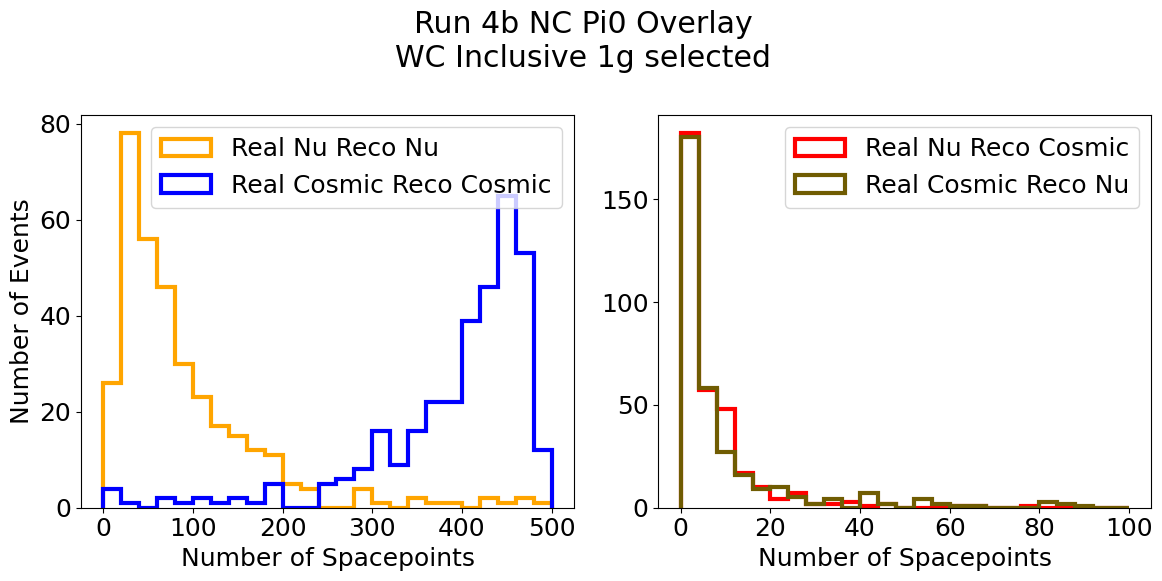

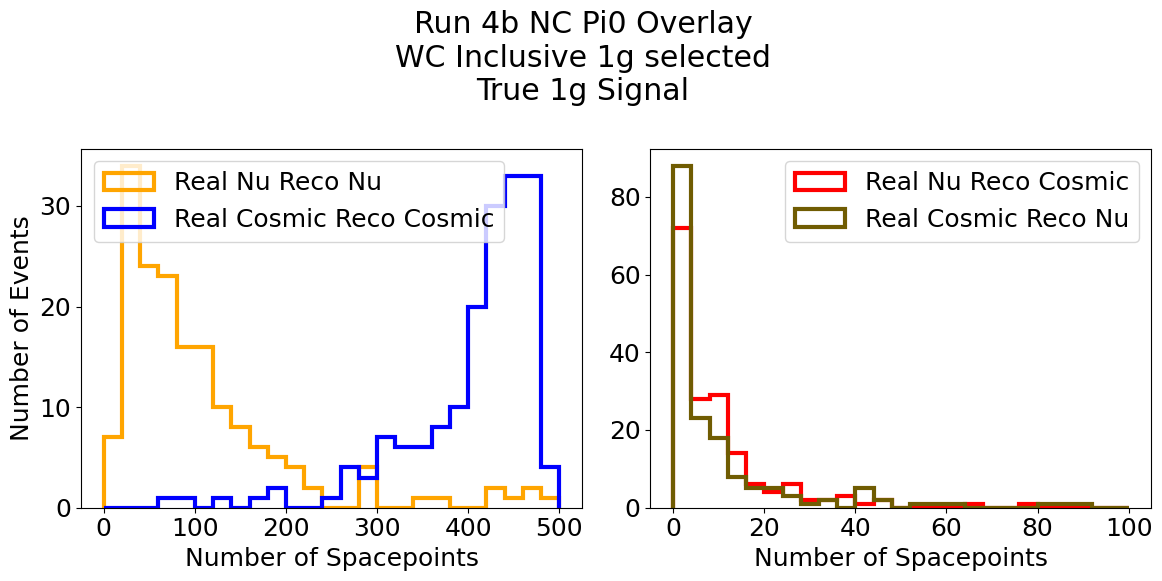

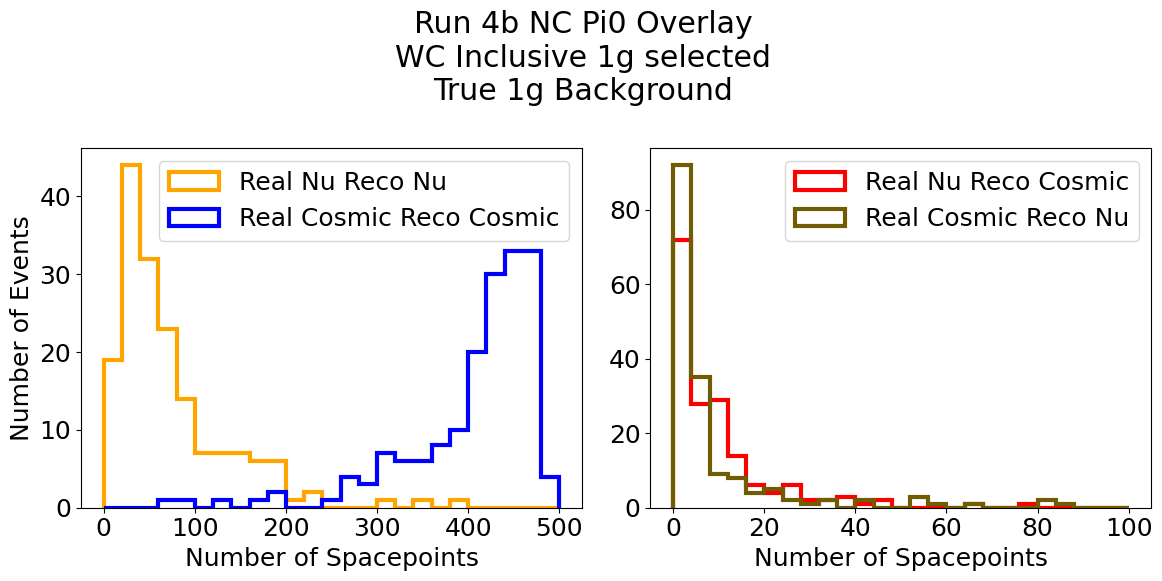

In [38]:
bins_correct = np.linspace(0, 500, 26)
bins_incorrect = np.linspace(0, 100, 26)
lw = 3

plt.rcParams.update({'font.size': 18})

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].hist(sel_real_nu_reco_nu, bins=bins_correct, histtype='step', lw=lw, color='orange', label='Real Nu Reco Nu')
axs[0].hist(sel_real_cosmic_reco_cosmic, bins=bins_correct, histtype='step', lw=lw, color='blue', label='Real Cosmic Reco Cosmic')
axs[0].legend()
axs[0].set_xlabel('Number of Spacepoints')
axs[0].set_ylabel('Number of Events')
axs[1].hist(sel_real_nu_reco_cosmic, bins=bins_incorrect, histtype='step', lw=lw, color='red', label='Real Nu Reco Cosmic')
axs[1].hist(sel_real_cosmic_reco_nu, bins=bins_incorrect, histtype='step', lw=lw, color='#705c02', label='Real Cosmic Reco Nu')
axs[1].legend()
axs[1].set_xlabel('Number of Spacepoints')
plt.suptitle("Run 4b NC Pi0 Overlay\nWC Inclusive 1g selected")
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].hist(sig_sel_real_nu_reco_nu, bins=bins_correct, histtype='step', lw=lw, color='orange', label='Real Nu Reco Nu')
axs[0].hist(sig_sel_real_cosmic_reco_cosmic, bins=bins_correct, histtype='step', lw=lw, color='blue', label='Real Cosmic Reco Cosmic')
axs[0].legend()
axs[0].set_xlabel('Number of Spacepoints')
axs[0].set_ylabel('Number of Events')
axs[1].hist(sig_sel_real_nu_reco_cosmic, bins=bins_incorrect, histtype='step', lw=lw, color='red', label='Real Nu Reco Cosmic')
axs[1].hist(sig_sel_real_cosmic_reco_nu, bins=bins_incorrect, histtype='step', lw=lw, color='#705c02', label='Real Cosmic Reco Nu')
axs[1].legend()
axs[1].set_xlabel('Number of Spacepoints')
plt.suptitle("Run 4b NC Pi0 Overlay\nWC Inclusive 1g selected\nTrue 1g Signal")
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].hist(bkg_sel_real_nu_reco_nu, bins=bins_correct, histtype='step', lw=lw, color='orange', label='Real Nu Reco Nu')
axs[0].hist(bkg_sel_real_cosmic_reco_cosmic, bins=bins_correct, histtype='step', lw=lw, color='blue', label='Real Cosmic Reco Cosmic')
axs[0].legend()
axs[0].set_xlabel('Number of Spacepoints')
axs[0].set_ylabel('Number of Events')
axs[1].hist(bkg_sel_real_nu_reco_cosmic, bins=bins_incorrect, histtype='step', lw=lw, color='red', label='Real Nu Reco Cosmic')
axs[1].hist(bkg_sel_real_cosmic_reco_nu, bins=bins_incorrect, histtype='step', lw=lw, color='#705c02', label='Real Cosmic Reco Nu')
axs[1].legend()
axs[1].set_xlabel('Number of Spacepoints')
plt.suptitle("Run 4b NC Pi0 Overlay\nWC Inclusive 1g selected\nTrue 1g Background")
plt.tight_layout()
plt.show()


# Plot in 3D

In [40]:
include_non_downsampled_points = True

index = 1

run = rse[index, 0]
subrun = rse[index, 1]
event = rse[index, 2]

print("run, subrun, event:", run, subrun, event)

fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scene'}]])

# these are only added to set the camera at a better position
fig.add_trace(go.Scatter3d(
    x=expanded_detector_boundary_points[:, 2],
    y=expanded_detector_boundary_points[:, 0],
    z=expanded_detector_boundary_points[:, 1],
    mode='markers',
    marker=dict(
        size=0.2,
        color='black',
        opacity=0.8
    ),
    name='Expanded TPC Boundary'
))

fig.add_trace(go.Scatter3d(
    x=detector_boundary_points[:, 2],
    y=detector_boundary_points[:, 0],
    z=detector_boundary_points[:, 1],
    mode='markers',
    marker=dict(
        size=1,
        color='black',
        opacity=0.8
    ),
    name='TPC Boundary'
))

fig.add_trace(go.Scatter3d(
    x=[reco_nu_vtx[index][2]],
    y=[reco_nu_vtx[index][0]],
    z=[reco_nu_vtx[index][1]],
    mode='markers',
    marker=dict(size=10, color='purple', opacity=1),
    name='Reco Neutrino Vertex',
    visible='legendonly'
))

fig.add_trace(go.Scatter3d(
    x=[true_nu_vtx[index][2]],
    y=[true_nu_vtx[index][0]],
    z=[true_nu_vtx[index][1]],
    mode='markers',
    marker=dict(size=10, color='green', opacity=1),
    name='True Neutrino Vertex',
    visible='legendonly'

))


if include_non_downsampled_points:
    fig.add_trace(go.Scatter3d(
        x=Tcluster_spacepoints[index][:, 2],
        y=Tcluster_spacepoints[index][:, 0],
        z=Tcluster_spacepoints[index][:, 1],
        mode='markers',
        marker=dict(
            size=1,
            color="blue",
            opacity=0.8
        ),
        name='Tcluster Spacepoints',
        visible='legendonly'
    ))

fig.add_trace(go.Scatter3d(
    x=downsampled_Tcluster_spacepoints[index][:, 2],
    y=downsampled_Tcluster_spacepoints[index][:, 0],
    z=downsampled_Tcluster_spacepoints[index][:, 1],
    mode='markers',
    marker=dict(
        size=1,
        color="blue",
        opacity=0.8
    ),
    name='Downsampled Tcluster Spacepoints',
    visible='legendonly'
))

if include_non_downsampled_points:
    fig.add_trace(go.Scatter3d(
        x=Trec_spacepoints[index][:, 2],
        y=Trec_spacepoints[index][:, 0],
        z=Trec_spacepoints[index][:, 1],
        mode='markers',
        marker=dict(
            size=1,
            color='red',
            opacity=0.8
        ),
        name='Trec Spacepoints',
        visible='legendonly'
    ))

fig.add_trace(go.Scatter3d(
    x=downsampled_Trec_spacepoints[index][:, 2],
    y=downsampled_Trec_spacepoints[index][:, 0],
    z=downsampled_Trec_spacepoints[index][:, 1],
    mode='markers',
    marker=dict(
        size=1,
        color='red',
        opacity=0.8
    ),
    name='Downsampled Trec Spacepoints',
    visible='legendonly'
))

if include_non_downsampled_points:
    fig.add_trace(go.Scatter3d(
        x=TrueEDep_spacepoints[index][:, 2],
        y=TrueEDep_spacepoints[index][:, 0],
        z=TrueEDep_spacepoints[index][:, 1],
        mode='markers',
        marker=dict(
            size=1,
            color='orange',
            opacity=0.8
        ),
        name='TrueEDep Spacepoints',
        visible='legendonly'
    ))

fig.add_trace(go.Scatter3d(
    x=downsampled_TrueEDep_spacepoints[index][:, 2],
    y=downsampled_TrueEDep_spacepoints[index][:, 0],
    z=downsampled_TrueEDep_spacepoints[index][:, 1],
    mode='markers',
    marker=dict(
        size=3,
        color='orange',
        opacity=0.8
    ),
    name='Downsampled TrueEDep Spacepoints',
    visible='legendonly'
))

fig.add_trace(go.Scatter3d(
    x=real_nu_reco_nu_downsampled_spacepoints[index][:, 2],
    y=real_nu_reco_nu_downsampled_spacepoints[index][:, 0],
    z=real_nu_reco_nu_downsampled_spacepoints[index][:, 1],
    mode='markers',
    marker=dict(
        size=3,
        color='orange',
        opacity=0.8
    ),
    name='Real Nu Reco Nu Spacepoints',
))

fig.add_trace(go.Scatter3d(
    x=real_nu_reco_cosmic_downsampled_spacepoints[index][:, 2],
    y=real_nu_reco_cosmic_downsampled_spacepoints[index][:, 0],
    z=real_nu_reco_cosmic_downsampled_spacepoints[index][:, 1],
    mode='markers',
    marker=dict(
        size=3,
        color='red',
        opacity=0.8
    ),
    name='Real Nu Reco Cosmic Spacepoints',
))

fig.add_trace(go.Scatter3d(
    x=real_cosmic_reco_nu_downsampled_spacepoints[index][:, 2],
    y=real_cosmic_reco_nu_downsampled_spacepoints[index][:, 0],
    z=real_cosmic_reco_nu_downsampled_spacepoints[index][:, 1],
    mode='markers',
    marker=dict(
        size=3,
        color='brown',
        opacity=0.8
    ),
    name='Real Cosmic Reco Nu Spacepoints',
))

fig.add_trace(go.Scatter3d(
    x=real_cosmic_reco_cosmic_downsampled_spacepoints[index][:, 2],
    y=real_cosmic_reco_cosmic_downsampled_spacepoints[index][:, 0],
    z=real_cosmic_reco_cosmic_downsampled_spacepoints[index][:, 1],
    mode='markers',
    marker=dict(
        size=3,
        color='blue',
        opacity=0.8
    ),
    name='Real Cosmic Reco Cosmic Spacepoints',
))

fig.update_layout(
    scene=dict(
        xaxis_title='z',
        yaxis_title='x',
        zaxis_title='y',
        aspectratio=dict(
            x=5,
            y=3,
            z=1
        ),
    ),
    width=2000,
    height=1200,
    autosize=False,
    scene_camera=dict(
        eye=dict(x=-1.5, y=-1.5, z=1.5)
    )
)

fig.show(renderer="browser")


run, subrun, event: 20082 19 990
